In [10]:
%reload_ext autoreload
%autoreload 2

In [11]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    compress_repeated_epochs,
    batch_analysis,
    add_new_deep_sup,
    custom_plots,
)
from ripple_heterogeneity.replay import (
    replay_run,
    replay_fig,
    replay_participation,
    replay_participation_all_replays,
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
import random
from matplotlib.ticker import AutoMinorLocator
import logging

logging.basicConfig(level=logging.INFO)


In [12]:
functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [23]:
# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_v7"
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay'

df = replay_run.load_results(save_path, pre_task_post=True)


In [14]:
# df.basepath.unique()
v7_run_basepaths = ['Z:\\Data\\GrosmarkAD\\Achilles\\Achilles_10252013',
       'Z:\\Data\\GrosmarkAD\\Achilles\\Achilles_11012013',
       'Z:\\Data\\GrosmarkAD\\Buddy\\Buddy_06272013',
       'Z:\\Data\\GrosmarkAD\\Cicero\\Cicero_09012014',
       'Z:\\Data\\GrosmarkAD\\Cicero\\Cicero_09102014',
       'Z:\\Data\\GrosmarkAD\\Cicero\\Cicero_09172014',
       'Z:\\Data\\GrosmarkAD\\Gatsby\\Gatsby_08022013',
       'Z:\\Data\\GrosmarkAD\\Gatsby\\Gatsby_08282013',
       'Z:\\Data\\HMC1\\day8', 'Z:\\Data\\Kenji\\ec014.459_480']
temp_df = pd.DataFrame()
for basepath in v7_run_basepaths:
       temp_df = pd.concat([temp_df, df[df.basepath == basepath]], ignore_index=True)
# a,b,c = np.intersect1d(df.basepath.unique(), v7_run_basepaths, return_indices=True)
df = temp_df

In [24]:
# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_v7"
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay'

# save_path_cur_analysis = (
#     r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_v7_sessions_task_post"
# )
save_path_cur_analysis = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_all_sessions_task_post"
)
batch_analysis.run(
    df,
    save_path_cur_analysis,
    replay_participation_all_replays.run,
    parallel=True,
    verbose=True,
    overwrite=False,
    skip_if_error=False,
    replay_df=df,
    replay_save_path=save_path,
    alpha=0.05,
    min_spk_count=0,
)

# read back in
# save_path_cur_analysis = (
#     r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_v7_sessions_task_post"
# )
sessions = glob.glob(save_path_cur_analysis + os.sep + "*.pkl")
par_df = pd.DataFrame()
for session in sessions:
    with open(session, "rb") as f:
        results = pickle.load(f)
    par_df = pd.concat([par_df, results])


100%|██████████| 63/63 [00:11<00:00,  5.35it/s] 


In [25]:
par_df = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(par_df)
for basepath in par_df.basepath.unique():
    par_df.loc[par_df.basepath == basepath, "animal_id"] = loading.get_animal_id(basepath)


Text(0, 0.5, 'replay participation prob.')

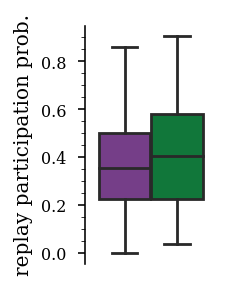

In [84]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

# keep_idx = (par_df.n_replays > 30) & (~par_df.basepath.str.contains('GirardeauG'))
keep_idx = (par_df.n_replays > 30)

sns.boxplot(
    x="epoch",
    y="replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
# sns.stripplot(
#     x="epoch",
#     y="replay_par",
#     hue="deepSuperficial",
#     hue_order=group_colors.keys(),
#     data=par_df[keep_idx],
#     dodge=True,
#     color="k",
#     size=3,
#     alpha=0.5,
# )
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.get_legend().remove()
ax.set_xlabel("")
ax.set_ylabel("replay participation prob.")

# plt.savefig(
#     os.path.join(fig_save_path, "replay_participation_05_11_22.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )
# par_df[keep_idx].basepath.unique()

In [105]:
from scipy.stats import ranksums
pval = []
for i in range(0,50,1):
    keep_idx = (par_df.n_replays > i)
    m1 = ranksums(
        par_df[keep_idx & (par_df.deepSuperficial == "Deep")].replay_par,
        par_df[keep_idx & (par_df.deepSuperficial == "Superficial")].replay_par,
    )
    pval.append(m1.pvalue)
    print(m1,i)

RanksumsResult(statistic=1.578981007750604, pvalue=0.11434041339880355) 0
RanksumsResult(statistic=0.7685665623466448, pvalue=0.4421506620038863) 1
RanksumsResult(statistic=0.9275077030086172, pvalue=0.3536629942084959) 2
RanksumsResult(statistic=0.49090414860512005, pvalue=0.6234942427042138) 3
RanksumsResult(statistic=0.44393230432973757, pvalue=0.6570915279661478) 4
RanksumsResult(statistic=0.39244028140546977, pvalue=0.6947329279303229) 5
RanksumsResult(statistic=0.18152401155322692, pvalue=0.855956287721327) 6
RanksumsResult(statistic=0.18152401155322692, pvalue=0.855956287721327) 7
RanksumsResult(statistic=0.2766869890229944, pvalue=0.7820204632475515) 8
RanksumsResult(statistic=0.2766869890229944, pvalue=0.7820204632475515) 9
RanksumsResult(statistic=0.1807158239431226, pvalue=0.8565906375807778) 10
RanksumsResult(statistic=0.21979761546616688, pvalue=0.826028776807908) 11
RanksumsResult(statistic=-0.5710618165761506, pvalue=0.5679577404875928) 12
RanksumsResult(statistic=-0.728

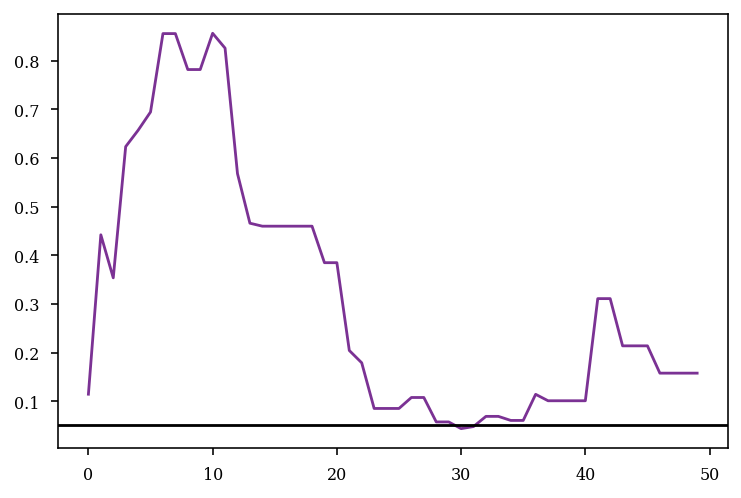

In [108]:
plt.plot(range(0,50,1), pval)
plt.axhline(0.05, color="k")

In [99]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder

temp_df = par_df[(par_df.deepSuperficial != "middle") & (par_df.n_replays > 30)]

lbl=LabelEncoder()
temp_df['basepath_encoded'] = lbl.fit_transform(temp_df[['basepath']])
temp_df['deepSuperficial_encoded'] = lbl.fit_transform(temp_df[['deepSuperficial']])

temp_df["Intercept"] = 1
exog = temp_df[["Intercept", "deepSuperficial_encoded"]]
md = sm.MixedLM(temp_df["replay_par"], exog, groups=temp_df["basepath_encoded"], exog_re=exog["Intercept"])
mdf = md.fit()
print(mdf.summary())

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    replay_par
No. Observations:    601        Method:                REML      
No. Groups:          24         Scale:                 0.0388    
Min. group size:     4          Log-Likelihood:        101.4706  
Max. group size:     55         Converged:             Yes       
Mean group size:     25.0                                        
-----------------------------------------------------------------
                        Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.395    0.019 21.193 0.000  0.359  0.432
deepSuperficial_encoded 0.040    0.022  1.818 0.069 -0.003  0.082
Intercept Var           0.006    0.012                           



In [ ]:
pval = []
for i in range(0,100,1):
    temp_df = par_df[(par_df.deepSuperficial != "middle") & (par_df.n_replays > i)]

    lbl=LabelEncoder()
    temp_df['basepath_encoded'] = lbl.fit_transform(temp_df[['basepath']])
    temp_df['deepSuperficial_encoded'] = lbl.fit_transform(temp_df[['deepSuperficial']])

    temp_df["Intercept"] = 1
    exog = temp_df[["Intercept", "deepSuperficial_encoded"]]
    md = sm.MixedLM(temp_df["replay_par"], exog, groups=temp_df["basepath_encoded"], exog_re=exog["Intercept"])
    mdf = md.fit()
    pval.append(mdf.pvalues.deepSuperficial_encoded)

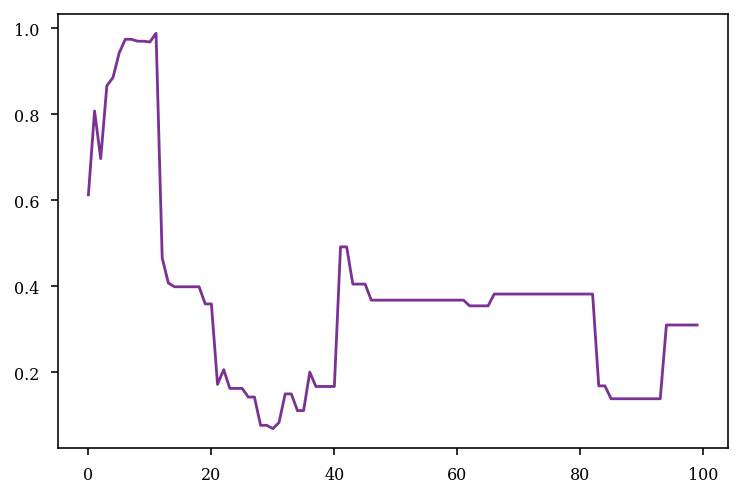

In [102]:
plt.plot(range(0,100,1), pval)


In [104]:
np.argmin(pval),np.min(pval)

(30, 0.06904692517789855)

In [74]:
# par_df["forward_reverse_ratio"] = (
#     par_df.forward_replay_par - par_df.reverse_replay_par
# ) / (par_df.forward_replay_par + par_df.reverse_replay_par)

par_df["forward_reverse_ratio"] = (
    par_df.forward_replay_par - par_df.reverse_replay_par
)

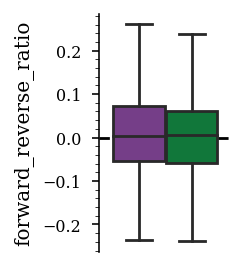

In [75]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(
    x="epoch",
    y="forward_reverse_ratio",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
    # boxprops=dict(alpha=.7)

# sns.stripplot(
#     x="epoch",
#     y="forward_reverse_ratio",
#     hue="deepSuperficial",
#     hue_order=group_colors.keys(),
#     data=par_df,
#     dodge=True,
#     color="k",
#     size=3,
#     alpha=0.5,
# )
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.get_legend().remove()
ax.set_xlabel("")
ax.axhline(0, linestyle="--", color="k",zorder=-1000)

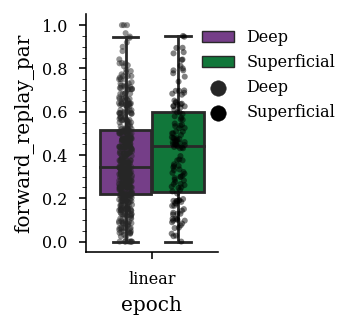

In [76]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

sns.boxplot(
    x="epoch",
    y="forward_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
sns.stripplot(
    x="epoch",
    y="forward_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
# plt.yscale("log")

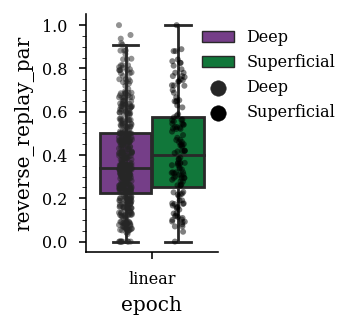

In [77]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

sns.boxplot(
    x="epoch",
    y="reverse_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
sns.stripplot(
    x="epoch",
    y="reverse_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
# plt.yscale("log")

In [78]:
# par_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_v7_task_post.csv")
# replay_participation_for_all_sessions_task_post
par_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_all_sessions_task_post.csv")
